In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        continue

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [39]:
import fastai
from fastai.vision.all import *
from tqdm import tqdm
from glob import glob
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.utils.class_weight import compute_class_weight
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score,classification_report
import matplotlib.pyplot as plt

In [40]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
N_CLASSES = 14

In [41]:
SEED = 85
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [42]:
labels_train_val = pd.read_csv('/kaggle/input/data/train_val_list.txt')
labels_train_val.columns = ['Image_Index']
labels_test = pd.read_csv('/kaggle/input/data/test_list.txt')
labels_test.columns = ['Image_Index']
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
# NIH Dataset Labels CSV File 
labels_df = pd.read_csv('/kaggle/input/data-entry-2017-v2020/Data_Entry_2017_v2020.csv')
print(labels_df.shape)
labels_df.columns = ['Image Index', 'Finding_Labels', 'Follow-Up #', 'Patient ID',
                  'Patient Age', 'Patient Gender', 'View Position',
                  'OriginalImage[Width', 'Height]',
                  'OriginalImagePixelSpacing[x',
                  'y]']
# One hot encoding
for diseases in tqdm(disease_labels): 
    labels_df[diseases] = labels_df['Finding_Labels'].map(lambda result: 1 if diseases in result else 0)

# labels_df=labels_df[labels_df.Finding_Labels != 'No Finding']
print(labels_df.shape)

(112120, 11)


100%|██████████| 14/14 [00:01<00:00, 13.29it/s]

(112120, 25)


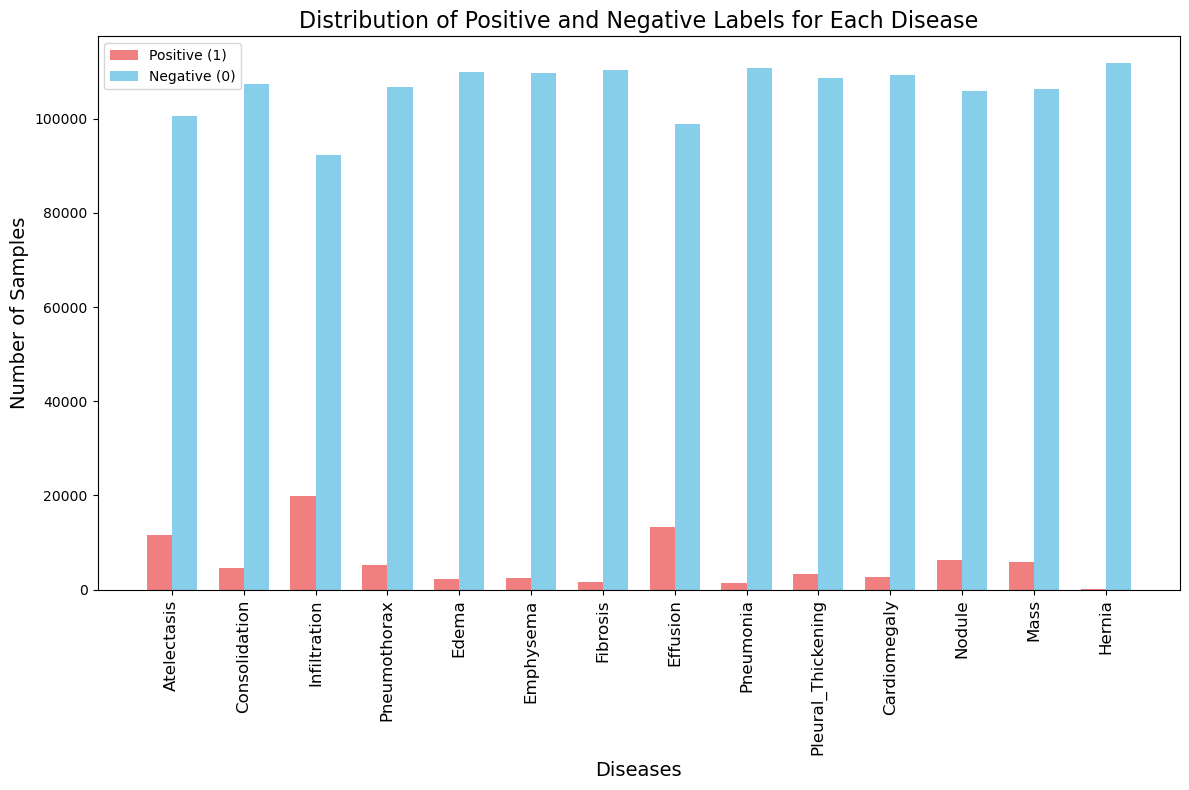

In [43]:
# Calculate positive and negative counts for each disease
positive_counts = []
negative_counts = []

for disease in disease_labels:
    # Count positive (1) and negative (0) labels for each disease
    positive_counts.append((labels_df[disease] == 1).sum())
    negative_counts.append((labels_df[disease] == 0).sum())

# Convert lists to arrays for plotting
positive_counts = np.array(positive_counts)
negative_counts = np.array(negative_counts)

# Create the plot
bar_width = 0.35
index = np.arange(len(disease_labels))

# Plot positive and negative counts
plt.figure(figsize=(12, 8))
bar1 = plt.bar(index, positive_counts, bar_width, label='Positive (1)', color='lightcoral')
bar2 = plt.bar(index + bar_width, negative_counts, bar_width, label='Negative (0)', color='skyblue')

# Add labels and title
plt.xlabel('Diseases', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Distribution of Positive and Negative Labels for Each Disease', fontsize=16)
plt.xticks(index + bar_width / 2, disease_labels, rotation=90, fontsize=12)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [44]:
unique_patients = np.unique(labels_df['Patient ID'])
unique_patients

array([    1,     2,     3, ..., 30803, 30804, 30805])

In [45]:

labels_df['Finding_Labels'] = labels_df['Finding_Labels'].apply(lambda s: [l for l in str(s).split('|')])

num_glob = glob('/kaggle/input/data/*/images/*.png')
img_path = {os.path.basename(x): x for x in num_glob}

labels_df['Paths'] = labels_df['Image Index'].map(img_path.get)
labels_df

,Image Index,Finding_Labels,Follow-Up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Paths
0,00000001_000.png,[Cardiomegaly],0,1,57,M,PA,2682,2749,0.143,...,0,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,1,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_002.png
3,00000002_000.png,[No Finding],0,2,80,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_001/images/00000002_000.png
4,00000003_001.png,[Hernia],0,3,74,F,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,1,/kaggle/input/data/images_001/images/00000003_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,"[Mass, Pneumonia]",1,30801,38,M,PA,2048,2500,0.168,...,0,0,0,1,0,0,0,1,0,/kaggle/input/data/images_012/images/00030801_001.png
112116,00030802_000.png,[No Finding],0,30802,28,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_012/images/00030802_000.png
112117,00030803_000.png,[No Finding],0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_012/images/00030803_000.png
112118,00030804_000.png,[No Finding],0,30804,29,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_012/images/00030804_000.png


In [46]:
unique_patients = np.unique(labels_df['Patient ID'])
len(unique_patients)

30805

In [47]:
from sklearn.model_selection import train_test_split

# train-70
# val-10
# test-20
train_val_df_patients, test_df_patients = train_test_split(unique_patients, test_size = 0.2,random_state = SEED, shuffle= True)

train_df_patients, valid_df_patients = train_test_split(train_val_df_patients, 
                                                        test_size=0.125,  # 0.125 of 80% is 10%
                                                        random_state=SEED, 
                                                        shuffle=True)
len(train_val_df_patients)

24644

In [48]:
train_df = labels_df[labels_df['Patient ID'].isin(train_df_patients)]
val_df = labels_df[labels_df['Patient ID'].isin(valid_df_patients)]
test_df = labels_df[labels_df['Patient ID'].isin(test_df_patients)]

In [49]:
labels_df.shape
print('train size', train_df.shape[0])
print('test size', val_df.shape[0])

train size 78691
test size 11073


In [50]:
class ChestXrayDataSet(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df: DataFrame containing image paths and labels.
            transform: optional transform to be applied on a sample.
        """
        self.df = df
        self.image_paths = df['Paths'].values
        self.labels = df[disease_labels].values
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of the item.

        Returns:
            image and its labels.
        """
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_paths)

In [51]:
# Define the model architecture
class DenseNet121(nn.Module):
    """Model modified for multi-label classification."""
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [52]:
# Function to compute AUCs
def compute_AUCs(gt, pred):
    """Computes Area Under the Curve (AUC) from prediction scores."""
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

In [53]:
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    gt = torch.FloatTensor().cuda()
    pred = torch.FloatTensor().cuda()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.cuda(), targets.cuda()

            # Reshape inputs for 10 crops (batch_size * 10, 3, 224, 224)
            bs, ncrops, c, h, w = inputs.size()  # ncrops is 10
            inputs = inputs.view(-1, c, h, w)

            # Forward pass (run the 10 crops through the model)
            outputs = model(inputs)

            # Reshape the outputs back (batch_size, 10, n_classes) and average over crops
            outputs = outputs.view(bs, ncrops, -1).mean(1)

            # Compute loss
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Accumulate ground truth and predictions for AUC calculation
            gt = torch.cat((gt, targets), 0)
            pred = torch.cat((pred, outputs), 0)

    val_loss /= len(val_loader)
    AUROCs = compute_AUCs(gt, pred)
    val_auc = np.array(AUROCs).mean()

    return val_loss, val_auc


In [54]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Define image transformations for training and validation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.TenCrop(224),  # this crops 10 images
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),  # convert to tensor
    transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))  # normalize each crop
])


In [55]:
# Create datasets and data loaders
train_dataset = ChestXrayDataSet(train_df, transform=train_transform)
val_dataset = ChestXrayDataSet(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [56]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Initialize an array to hold class weights for each label
class_weights = []

# Compute class weights for each label
for label in disease_labels:
    label_weights = compute_class_weight('balanced', classes=np.unique(train_df[label]), 
                                         y=train_df[label])
    class_weights.append(label_weights[1])  # We only need the positive class weight

# Convert the class weights to a tensor
class_weights_tensor = torch.FloatTensor(class_weights).cuda()

In [57]:
# # Adjust loss function to use class weights
# #class_weights_tensor = torch.FloatTensor(class_weights).cuda()
# criterion = nn.BCEWithLogitsLoss(weights=class_weights).cuda()  # Use weighted BCE Loss

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor).cuda()

In [58]:
# # Adjust model training loop accordingly
# def train_one_epoch(model, train_loader, criterion, optimizer):
#     model.train()
#     running_loss = 0.0

#     for i, (inputs, labels) in enumerate(train_loader):
#         inputs, labels = inputs.cuda(), labels.cuda()

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)

#         loss = criterion(outputs, labels)

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     return running_loss / len(train_loader)

In [59]:
# # Set up the model
# cudnn.benchmark = True

# model = DenseNet121(N_CLASSES).cuda()
# model = torch.nn.DataParallel(model).cuda()

In [60]:

# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [61]:
# # Train the model
# EPOCHS = 20
# for epoch in range(EPOCHS):
#     train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
#     val_loss, val_auc = validate(model, val_loader, criterion)

#     print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
    
#      # Save the model with the validation AUC in the filename
#     model_filename = f'chexnet_epoch_{epoch + 1}_auc_{val_auc:.4f}.pth'
#     torch.save(model.state_dict(), model_filename)
#     print(f'Model saved as {model_filename}')

In [62]:
# Load the saved model
model = DenseNet121(N_CLASSES).cuda()
model = torch.nn.DataParallel(model).cuda()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
model.load_state_dict(torch.load('/kaggle/input/optimized-class-weights-model/pytorch/default/1/chexnet_epoch_17_auc_0.8457.pth'))
#model.eval()

<All keys matched successfully>

In [64]:
# Apply the same transformations used for validation to the test dataset
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.TenCrop(224),  # this crops 10 images
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),  # convert to tensor
    transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))  # normalize each crop
])

In [65]:
test_dataset = ChestXrayDataSet(test_df, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [66]:
def test_model_with_metrics(model, test_loader, threshold=0.5):
    model.eval()
    gt = torch.FloatTensor().cuda()
    pred = torch.FloatTensor().cuda()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()

            bs, ncrops, c, h, w = inputs.size()
            inputs = inputs.view(-1, c, h, w)
            outputs = model(inputs)
            outputs = outputs.view(bs, ncrops, -1).mean(1)

            gt = torch.cat((gt, targets), 0)
            pred = torch.cat((pred, outputs), 0)

    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    pred_binary = (pred_np > threshold).astype(int)

    AUROCs = compute_AUCs(gt, pred)
    test_auc = np.array(AUROCs).mean()
    f1_scores = [f1_score(gt_np[:, i], pred_binary[:, i], zero_division=0) for i in range(N_CLASSES)]

    return test_auc, AUROCs, f1_scores, gt_np, pred_binary


In [67]:
def test_model_with_multilabel_f1(model, test_loader, threshold=0.5):
    model.eval()
    gt = torch.FloatTensor().cuda()  # ground truth
    pred = torch.FloatTensor().cuda()  # predictions

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()

            # Reshape inputs for 10 crops (batch_size * 10, 3, 224, 224)
            bs, ncrops, c, h, w = inputs.size()
            inputs = inputs.view(-1, c, h, w)

            # Forward pass (run the 10 crops through the model)
            outputs = model(inputs)

            # Reshape the outputs back (batch_size, 10, n_classes) and average over crops
            outputs = outputs.view(bs, ncrops, -1).mean(1)

            # Accumulate ground truth and predictions
            gt = torch.cat((gt, targets), 0)
            pred = torch.cat((pred, outputs), 0)

    # Convert predictions and ground truth to numpy for F1 score calculation
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()

    # Apply threshold to predictions
    pred_binary = (pred_np > threshold).astype(int)

    # Compute Micro, Macro, and Weighted F1 Scores
    micro_f1 = f1_score(gt_np, pred_binary, average='micro', zero_division=0)
    macro_f1 = f1_score(gt_np, pred_binary, average='macro', zero_division=0)
    weighted_f1 = f1_score(gt_np, pred_binary, average='weighted', zero_division=0)

    # Generate a classification report for detailed per-class metrics
    class_report = classification_report(gt_np, pred_binary, target_names=disease_labels, zero_division=0)

    return micro_f1, macro_f1, weighted_f1, class_report

In [68]:
# def compute_confusion_matrices(gt, pred):
#     conf_matrices = {}
#     norm_conf_matrices = {}

#     for i, disease in enumerate(disease_labels):
#         cm = confusion_matrix(gt[:, i], pred[:, i])
#         conf_matrices[disease] = cm
#         norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalization
#         norm_conf_matrices[disease] = norm_cm

#     return conf_matrices, norm_conf_matrices


In [69]:
# # Run testing and compute AUC scores
# test_auc, per_class_auc = test_model(model, test_loader)

# # Run testing and compute AUC and F1 scores
test_auc, per_class_auc, f1_scores, gt_np, pred_binary = test_model_with_metrics(model, test_loader)

# Run the function to compute multi-label F1 scores
micro_f1, macro_f1, weighted_f1, class_report = test_model_with_multilabel_f1(model, test_loader)

In [70]:
# # Print the results
# print(f"Overall Test AUC: {test_auc:.4f}")
# for i, disease in enumerate(disease_labels):
#     print(f"AUC for {disease}: {per_class_auc[i]:.4f}")

# Print the results
print(f"Overall Test AUC: {test_auc:.4f}")
for i, disease in enumerate(disease_labels):
    print(f"AUC for {disease}: {per_class_auc[i]:.4f}, F1 Score for {disease}: {f1_scores[i]:.4f}")


print("#####################################################################################")

# Print the results
print(f"Micro F1 Score: {micro_f1:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")
print("\nClassification Report:\n", class_report)

Overall Test AUC: 0.8480
AUC for Atelectasis: 0.8215, F1 Score for Atelectasis: 0.3996
AUC for Consolidation: 0.8074, F1 Score for Consolidation: 0.2167
AUC for Infiltration: 0.7271, F1 Score for Infiltration: 0.4281
AUC for Pneumothorax: 0.8892, F1 Score for Pneumothorax: 0.3448
AUC for Edema: 0.9029, F1 Score for Edema: 0.2566
AUC for Emphysema: 0.9262, F1 Score for Emphysema: 0.3364
AUC for Fibrosis: 0.8302, F1 Score for Fibrosis: 0.1506
AUC for Effusion: 0.8829, F1 Score for Effusion: 0.5123
AUC for Pneumonia: 0.7656, F1 Score for Pneumonia: 0.0822
AUC for Pleural_Thickening: 0.8058, F1 Score for Pleural_Thickening: 0.1863
AUC for Cardiomegaly: 0.9077, F1 Score for Cardiomegaly: 0.2750
AUC for Nodule: 0.7903, F1 Score for Nodule: 0.2839
AUC for Mass: 0.8631, F1 Score for Mass: 0.3333
AUC for Hernia: 0.9518, F1 Score for Hernia: 0.3065
#####################################################################################
Micro F1 Score: 0.3340
Macro F1 Score: 0.2937
Weighted F1 Score

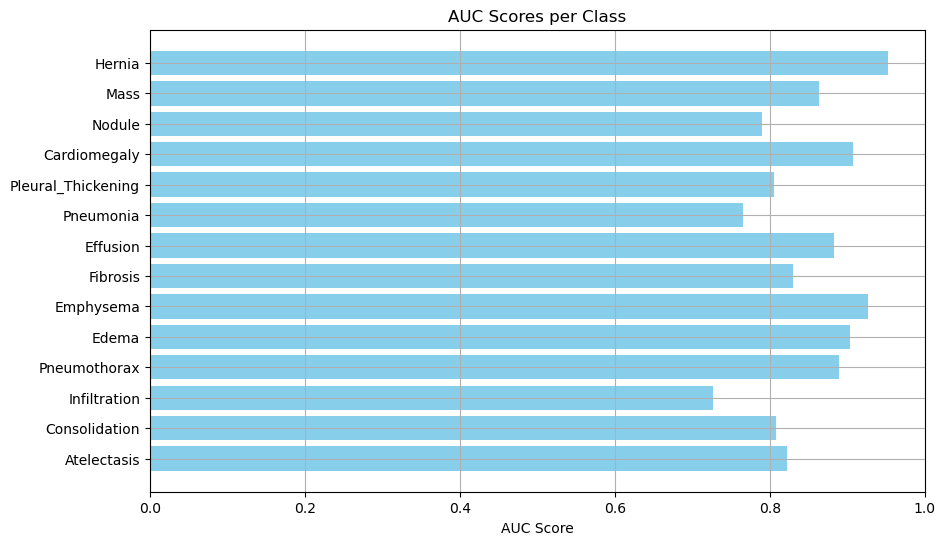

In [71]:
# Plotting the AUC scores for each class
plt.figure(figsize=(10, 6))
plt.barh(disease_labels, per_class_auc, color='skyblue')
plt.xlabel('AUC Score')
plt.title('AUC Scores per Class')
plt.xlim([0, 1])
plt.grid(True)
plt.show()

In [72]:
from sklearn.metrics import confusion_matrix


In [73]:
from sklearn.metrics import confusion_matrix

def compute_confusion_matrices(gt, pred):
    conf_matrices = {}
    norm_conf_matrices = {}

    # Compute per-class confusion matrices
    for i, disease in enumerate(disease_labels):
        cm = confusion_matrix(gt[:, i], pred[:, i])
        conf_matrices[disease] = cm
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalization
        norm_conf_matrices[disease] = norm_cm

    # Compute overall confusion matrix
    # Flatten the arrays to consider all predictions at once
    overall_cm = confusion_matrix(gt.flatten(), pred.flatten())
    overall_norm_cm = overall_cm.astype('float') / overall_cm.sum(axis=1)[:, np.newaxis]

    return conf_matrices, norm_conf_matrices, overall_cm, overall_norm_cm

# Now call this updated function in your main testing script
conf_matrices, norm_conf_matrices, overall_cm, overall_norm_cm = compute_confusion_matrices(gt_np, pred_binary)

# Display the overall confusion matrix and normalized version
print("Overall Confusion Matrix:")
print(overall_cm)
print("Normalized Overall Confusion Matrix:")
print(overall_norm_cm)


Overall Confusion Matrix:
[[264599  32285]
 [  6401   9699]]
Normalized Overall Confusion Matrix:
[[0.89125382 0.10874618]
 [0.39757764 0.60242236]]


In [74]:
# # Run testing and compute AUC, F1 scores, and get predictions
# #test_auc, per_class_auc, f1_scores, gt_np, pred_binary = test_model_with_metrics(model, test_loader)

# # Compute confusion matrices
# conf_matrices, norm_conf_matrices = compute_confusion_matrices(gt_np, pred_binary)

# # Display results
# print(f"Overall Test AUC: {test_auc:.4f}")
# for disease in disease_labels:
#     print(f"Confusion Matrix for {disease}:")
#     print(conf_matrices[disease])
#     print(f"Normalized Confusion Matrix for {disease}:")
#     print(norm_conf_matrices[disease])
